In [62]:
#import necessary package
import pycbc
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pycbc.frame import read_frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass, matched_filter,lowpass
from tqdm import tqdm
from pycbc.waveform import get_fd_waveform
from pycbc.psd.variation import calc_filt_psd_variation
from pycbc.vetoes import power_chisq
from tqdm import tqdm
from scipy.signal import convolve
from urllib.request import urlretrieve

In [65]:
#read in data
url = 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1257852928/H-H1_GWOSC_O3b_4KHZ_R1-1257852928-4096.gwf'
urlretrieve(url,'H-H1_GWOSC_O3b_4KHZ_R1-1257852928-4096.gwf')
channel_name = "H1:GWOSC-4KHZ_R1_STRAIN"
h1 = read_frame('H-H1_GWOSC_O3b_4KHZ_R1-1257852928-4096.gwf', channel_name)

In [66]:
h11 = np.nan_to_num(h1,nan=0)
h11 = np.nan_to_num(h1,nan=0)
h1 = pycbc.types.timeseries.TimeSeries(h11, delta_t=h1.delta_t)
h1 = highpass(h1, 10, 8)
psd2 = interpolate(welch(h1,seg_len = int((1/h1.delta_t)*8),seg_stride = int((1/h1.delta_t)*4)),1/h1.duration)

## Calculate regular SNR

In [7]:
ra = 5.3
dec = 4.5
psi = 2.6
tgps = 0
det_H1 = pycbc.detector.Detector('H1')
#antennna sensitivity
fp, fc = det_H1.antenna_pattern(right_ascension=ra, declination=dec, polarization=psi, t_gps=tgps)
#frequency range
minf = 20

mass1_det_frame = 100
mass2_det_frame = 100
distance_inj = 4500.  # in Mpc
inclination_inj = np.pi/4
phase_inj = 0.
flow = 20.
t0_inj = 300
fmax = 1600
# generate waveform
hpf, hcf = get_fd_waveform(approximant="IMRPhenomD",
                                        mass1 = mass1_det_frame,
                                        mass2 = mass2_det_frame,
                                        distance = distance_inj,
                                        inclination = inclination_inj,
                                        coa_phase = phase_inj,
                                        f_lower=flow, f_final=1/(2*h1.delta_t),
                                        delta_f=h1.delta_f)

template = fp*hpf + fc*hcf

SNR_orig_psd = matched_filter(template, h1, psd=psd2, low_frequency_cutoff=minf)

##  Calculate PSD variation and $\chi^{2}$ time series

In [25]:
psd_var = calc_filt_psd_variation(h1, segment=8, short_segment=0.25, psd_long_segment=512,
                                 psd_duration=8, psd_stride=4, psd_avg_method='median', low_freq=20,
                                 high_freq=480)

/home/jiayu217/anaconda3/envs/gwxphm/lib/python3.8/site-packages/pycbc/psd/variation.py:165: RuntimeWarning: divide by zero encountered in power
  fweight = freqs ** (-7./6.) * filt / numpy.sqrt(plong)


4073


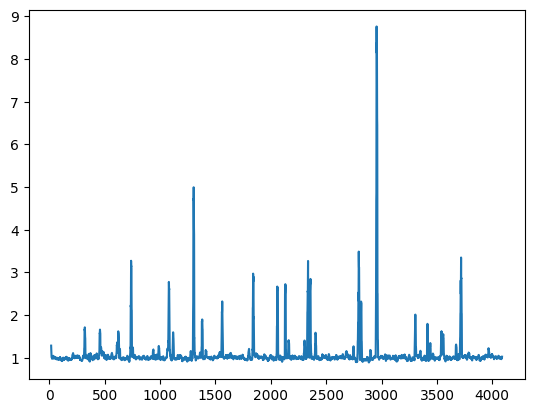

In [53]:
print(len(psd_var))
plt.plot(psd_var.sample_times,psd_var)

Text(0.5, 0, 'PSD variation statistics')

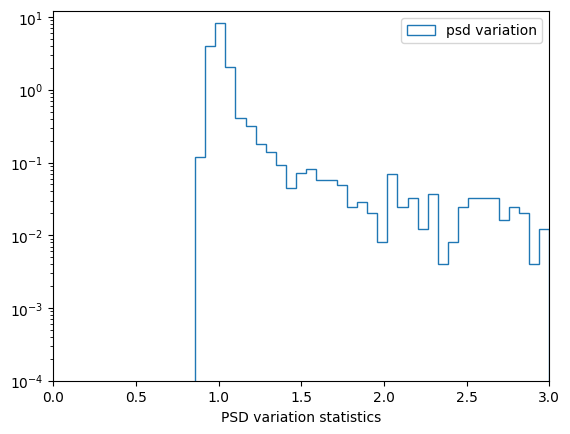

In [50]:
plt.hist(psd_var, histtype = 'step', bins = np.linspace(0,3,50),density = True, label = 'psd variation')
plt.yscale('log')
plt.ylim(bottom=1e-4)
plt.xlim(0,3)
plt.legend()
plt.xlabel('PSD variation statistics')

16777216


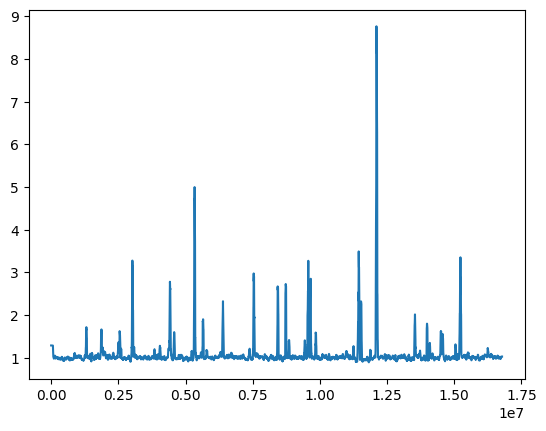

In [29]:
###Interpolated the psd variation t
psd_var_interpolated = np.interp(SNR_orig_psd.sample_times, psd_var.sample_times, psd_var)
print(len(psd_var_interpolated))
plt.plot(psd_var_interpolated)

Text(0.5, 0, 'PSD variation statistics')

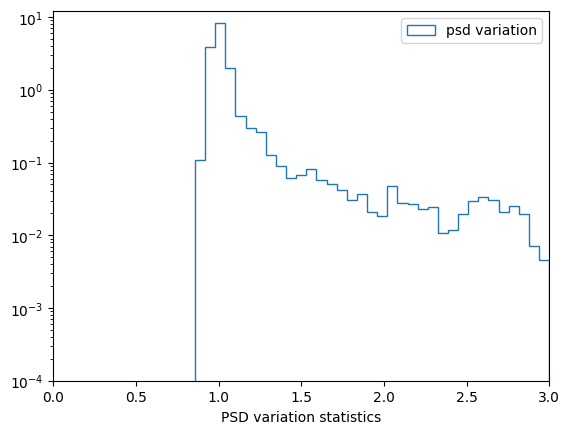

In [49]:
plt.hist(psd_var_interpolated, histtype = 'step', bins = np.linspace(0,3,50),density = True, label = 'psd variation')
plt.yscale('log')
plt.ylim(bottom=1e-4)
plt.xlim(0,3)
plt.legend()
plt.xlabel('PSD variation statistics')

In [16]:
num_bins = 16
chisq = power_chisq(template, h1, num_bins, psd2,
                                      low_frequency_cutoff=minf)

In [55]:
print(len(SNR_orig_psd))
print(len(chisq))

16777216
16777216


## Construct reweighted SNR

In [35]:
def snr_reweighted(snr, chisq_time, variation):
    criteria = chisq_time/variation
    weighted_snr = np.zeros(len(snr))
    for i in tqdm(range(len(criteria))):
        if criteria[i] <= 1:
            weighted_snr[i] = snr[i] * (variation**(-1/2))
        if criteria[i] >1:
            weighted_snr[i] = snr[i] * (((1/2)*(variation[i]**3+chisq_time[i]**3))**(-1/6))
    return weighted_snr

In [59]:
print(max(psd_var))
print(max(psd_var_interpolated))

8.762377449062965
8.762377449062965


(0.0, 400.0)

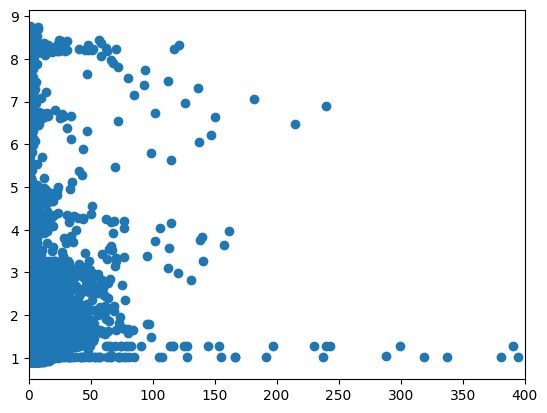

In [57]:
plt.scatter(np.abs(SNR_orig_psd[::100])**2,psd_var_interpolated[::100])
plt.xlim(0,400)

In [37]:
#compute the dynamically reweighted SNR
snr_corr = snr_reweighted(SNR_orig_psd, chisq, psd_var_interpolated)

  0%|                                                                                                                                        | 0/16777216 [00:00<?, ?it/s]/tmp/ipykernel_3385589/847894104.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  weighted_snr[i] = snr[i] * (((1/2)*(variation[i]**3+chisq_time[i]**3))**(-1/6))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16777216/16777216 [01:14<00:00, 225990.08it/s]


Text(0.5, 0, '$|z|^{2}$')

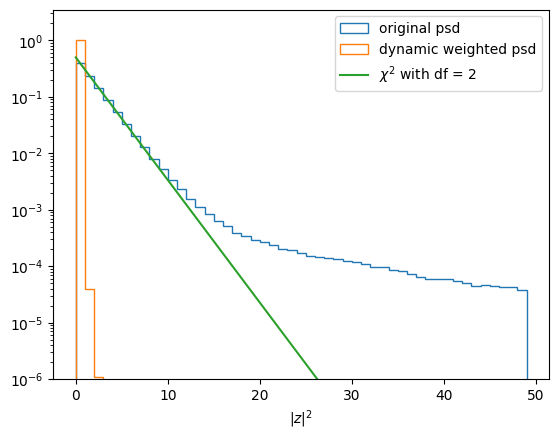

In [38]:
bins = np.arange(50)
plt.hist(abs(SNR_orig_psd)**2, histtype = 'step', bins = bins,density = True , label = 'original psd')
plt.hist(abs(snr_corr)**2, histtype = 'step', bins = bins,density = True, label = 'dynamic weighted psd')
plt.plot(np.arange(50), 0.5*np.exp(-0.5*np.arange(50)), label = '$\chi ^{2}$ with df = 2')
plt.yscale('log')
plt.ylim(bottom=1e-6)
plt.legend()
plt.xlabel('$|z|^{2}$')

Text(0.5, 0, '$|z|^{2}$')

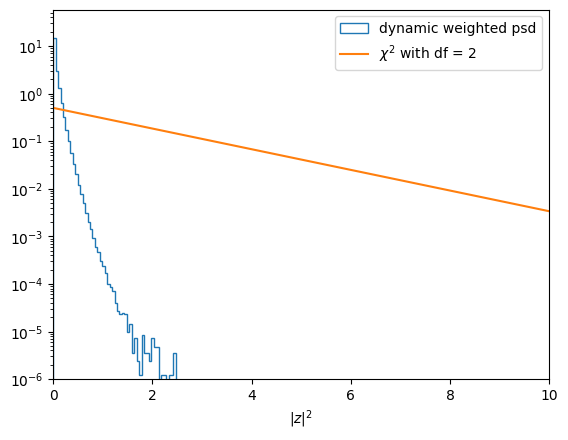

In [44]:
bins = np.arange(50)
#plt.hist(abs(SNR_orig_psd)**2, histtype = 'step', bins = bins,density = True , label = 'original psd')
plt.hist(abs(snr_corr)**2, histtype = 'step', bins = 50,density = True, label = 'dynamic weighted psd')
plt.plot(np.arange(50), 0.5*np.exp(-0.5*np.arange(50)), label = '$\chi ^{2}$ with df = 2')
plt.yscale('log')
plt.ylim(bottom=1e-6)
plt.xlim(0,10)
plt.legend()
plt.xlabel('$|z|^{2}$')